# Removing background by PCA
> Required for removing covariates in the distance matrix

- toc: true 
- badges: true
- comments: true

#### Some references
[Background removal with robust PCA](https://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/3.%20Background%20Removal%20with%20Robust%20PCA.ipynb)  
[A nice explanation of PCA](https://stats.stackexchange.com/questions/229092)

# Setup

## Expression file path

In [1]:
#collapse-hide
expression_file = '/scratch/sbanerj/trans-eqtl/input/gtex_v8/expression/gtex_ms_raw_std_protein_coding_lncRNA.txt'

## Python libraries

In [2]:
#collapse-hide
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy import stats
import os
from scipy.cluster import hierarchy as hc

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 300)

## Define some functions

1. Read GTEx data
2. Reduce matrix dimension
3. Calculate distance matrix
4. Plot heatmap

In [3]:
#collapse-hide
def read_gtex(filename): # returns N x G gene expression
    expr_list = list()
    donor_list = list()
    gene_list = list()
    with open(filename) as mfile:
        donor_list = mfile.readline().strip().split("\t")[1:]
        for line in mfile:
            linesplit = line.strip().split("\t")
            gene = linesplit[0].strip()
            gene_list.append(gene)
            expr = np.array([float(x) for x in linesplit[1:]])
            expr_list.append(expr)
    expr = np.transpose(np.array(expr_list))
    return expr, donor_list, gene_list

def get_pca(x, K):
    pca = PCA(n_components=K)
    pca.fit(x) # requires N x P (n_samples, n_features)
    x_pca = pca.transform(x)
    return x_pca

def get_distance(a, b):
    return np.linalg.norm(a - b)

def distance_matrix(x_pca):
    nsample = x_pca.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = get_distance(x_pca[i,:], x_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
    return distance_matrix

def pheatmap(ax, Xorig, title, norm = None):
    '''
    provide norm, if required
    where,
    norm = matplotlib.colors.DivergingNorm(vmin=0., vcenter=90., vmax=300.)
    '''

    # the zero distance between the same samples
    # is bad for the color scale.
    X = Xorig.copy()
    X[np.diag_indices(X.shape[0])] = np.nan
    cmap = plt.get_cmap("YlGnBu")
    cmap.set_bad('w')

    if norm is not None:
        im1 = ax.imshow(X, cmap = cmap, norm = norm, interpolation='nearest')
    else:
        im1 = ax.imshow(X, cmap = cmap, interpolation='nearest')       

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)

    ax.set_title(title, pad = 20)
    return

## Read data

In [4]:
#collapse-hide
gx, gxsamples, _ = read_gtex(expression_file)

## Calculate distance matrix

In [5]:
#collapse-hide
dm_gx = distance_matrix(get_pca(gx, 30))
o1 = hc.leaves_list(hc.linkage(dm_gx, method = 'centroid'))
mgx = dm_gx[o1, :][:, o1]

/usr/users/sbanerj/miniconda3/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


# Remove background using different methods

`np.linalg.eig` returns
- w : (M,) array. The eigenvalues, each repeated according to its multiplicity. The eigenvalues are not necessarily ordered. 
- v : (M, M) array. The normalized (unit “length”) eigenvectors, such that the column v[:,i] is the eigenvector corresponding to the eigenvalue w[i].

`np.linalg.svd (a, full_matrices = False)` returns
- u : (M, K) array. Unitary array(s).
- s : (K, ) array. Vector(s) with the singular values, within each vector sorted in descending order.
- vt : (K, N) array. Unitary array(s).


In [6]:
#collapse-hide
def remove_nfirst_pcs_svd(X, n=1):
    '''
    Using the svd module of numpy.linalg
    '''
    #mu = np.mean(X, axis = 0)
    #Xnorm = X - mu
    #U, S, Vt = np.linalg.svd(Xnorm, full_matrices=False)
    U, S, Vt = np.linalg.svd(X, full_matrices=False)
    Xhat = U[:, n:] @ np.diag(S[n:]) @ Vt[n:, :]
    #Xhat += mu
    return Xhat

def remove_nfirst_pcs_eig(X, n=1):
    '''
    Using the eig module of numpy.linalg
    '''
    #mu = np.mean(X, axis = 0)
    #Xnorm = X - mu
    #w, v = np.linalg.eig(Xnorm)
    w, v = np.linalg.eig(X)
    iord = np.argsort(w)[::-1]
    w = w[iord]
    v = v[:, iord]
    Xhat =  v[:, n:] @ np.diag(w[n:]) @ v[:, n:].T
    #Xhat += mu
    return Xhat

def remove_nfirst_pcs_skl(X, n = 1):
    '''
    Using the PCA module of sklearn
    '''
    nsamples = X.shape[0]
    nfeatures = X.shape[1]
    ncomp = min(nsamples, nfeatures)
    pca = PCA(n_components = ncomp)
    pca.fit(X)
    Xpcs = pca.transform(X)
    Xeig  = pca.components_
    mu = np.mean(X, axis=0)
    Xhat = np.dot(Xpcs[:, n:], Xeig[n:, :])
    Xhat += mu
    return Xhat

# Calculate

In [7]:
#collapse-show
mgx_n0_eig = remove_nfirst_pcs_eig(mgx, n=0)
mgx_n1_eig = remove_nfirst_pcs_eig(mgx, n=1)

mgx_n0_svd = remove_nfirst_pcs_svd(mgx, n=0)
mgx_n1_svd = remove_nfirst_pcs_svd(mgx, n=1)

mgx_n0_skl = remove_nfirst_pcs_skl(mgx, n=0)
mgx_n1_skl = remove_nfirst_pcs_skl(mgx, n=1)

# Plot

## Using numpy.linalg.eig

In [8]:
norm = matplotlib.colors.DivergingNorm(vmin=0., vcenter=75., vmax=300.)

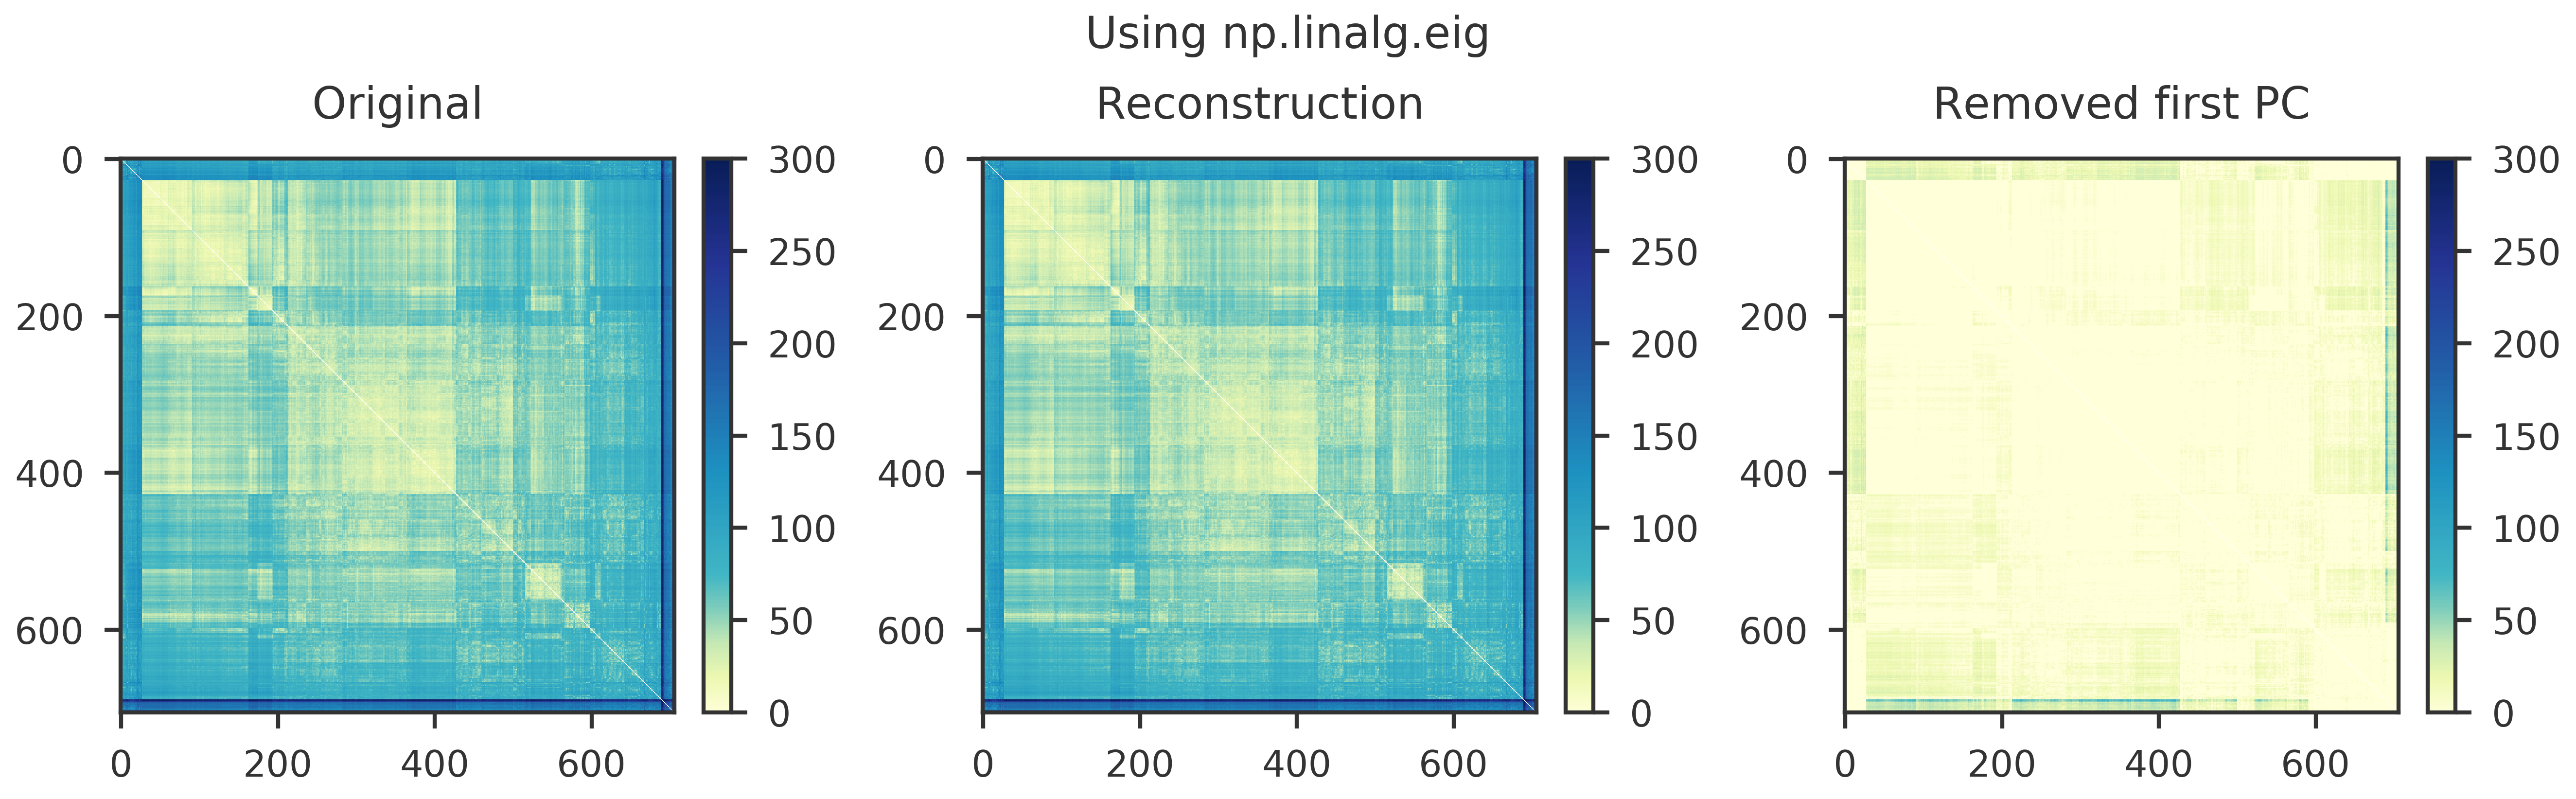

In [9]:
#collapse-show
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pheatmap(ax1, mgx, "Original", norm = norm)
pheatmap(ax2, mgx_n0_eig, "Reconstruction", norm = norm)
pheatmap(ax3, mgx_n1_eig, "Removed first PC", norm = norm)
fig.suptitle("Using np.linalg.eig")
plt.tight_layout()
plt.show()

## Using numpy.linalg.svd

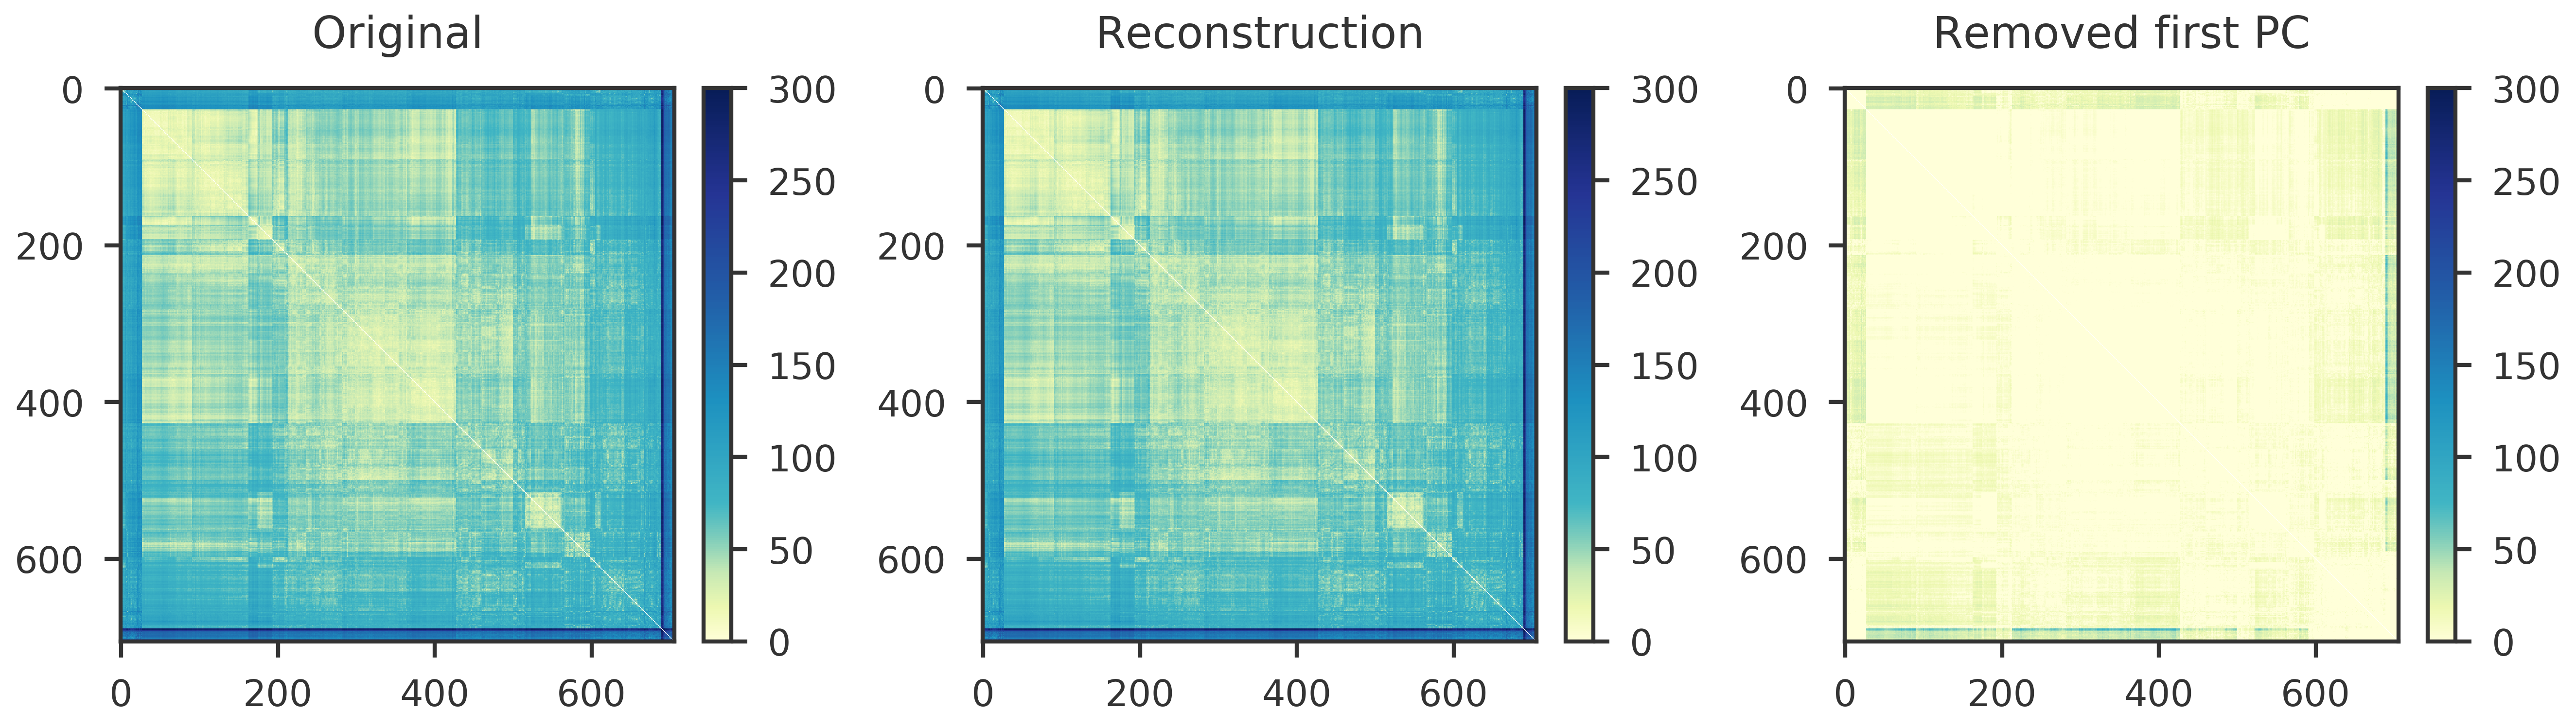

In [10]:
#collapse-show
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pheatmap(ax1, mgx, "Original", norm = norm)
pheatmap(ax2, mgx_n0_svd, "Reconstruction", norm = norm)
pheatmap(ax3, mgx_n1_svd, "Removed first PC", norm = norm)
plt.tight_layout()
plt.show()

## Using sklearn.PCA

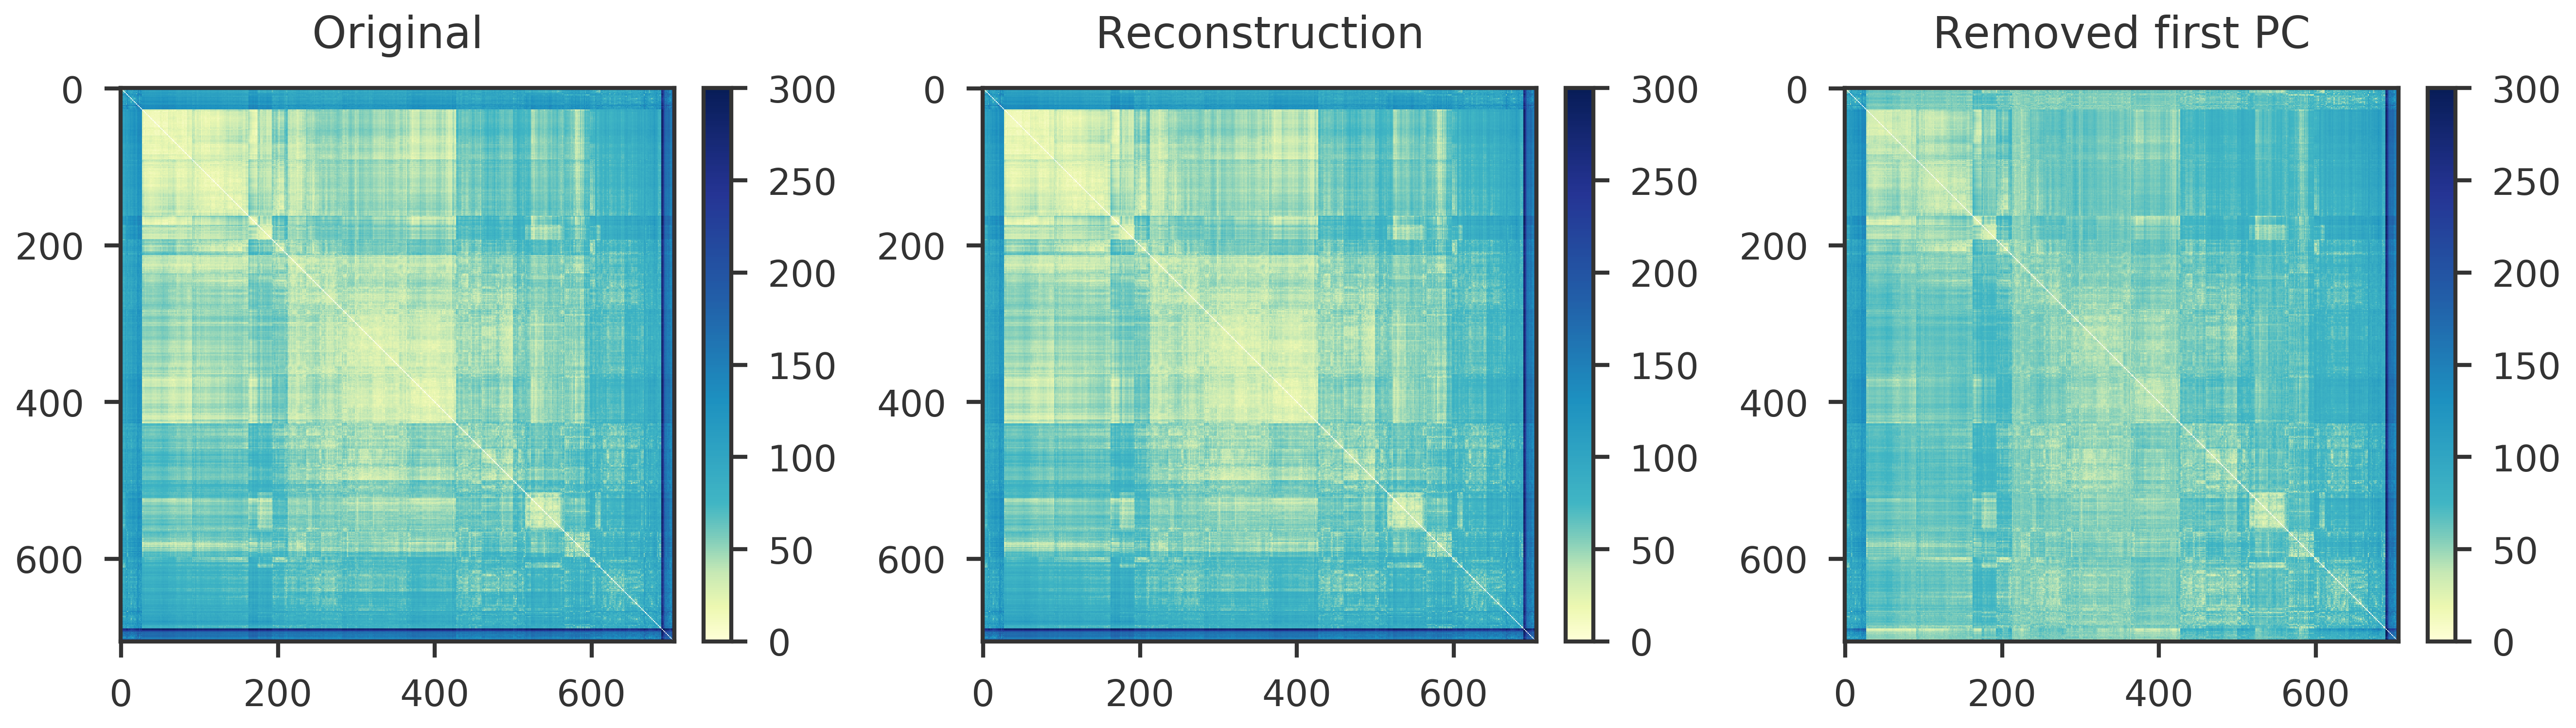

In [11]:
#collapse-show
fig = plt.figure(figsize = (18, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
pheatmap(ax1, mgx, "Original", norm = norm)
pheatmap(ax2, mgx_n0_skl, "Reconstruction", norm = norm)
pheatmap(ax3, mgx_n1_skl, "Removed first PC", norm = norm)
plt.tight_layout()
plt.show()

In [12]:
np.allclose(mgx_n1_svd, mgx_n1_eig)

True

### Note to self: 
The sklearn PCA centers the matrix before SVD internally. Hence, we have to add the mean of the rows for reconstruction. While removing PCs in symmetric matrix, it breaks the symmetry and cannot be used. 